In [114]:
import torch # Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

Using GPU: Tesla P100-PCIE-16GB


## Data preprocessing

In [143]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

BATCH_SIZE = 32

In [144]:
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_tfms = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [105]:
from torch.utils.data import DataLoader, Subset
import numpy as np

def train_test_split(dataset, train_split=0.8):
    num_train = int(len(dataset) * train_split)
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)

    train_indices = indices[:num_train]
    test_indices = indices[num_train:]

    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)

    return train_subset, test_subset

In [145]:
train_set = datasets.ImageFolder('/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train', transform=transform)
test_set = datasets.ImageFolder('/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test', transform=test_tfms)

## Data shuffling

In [24]:
total_dataset = torch.utils.data.ConcatDataset([train_set, test_set])
train_set, test_set = train_test_split(total_dataset)

## Data loaders

In [146]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [128]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

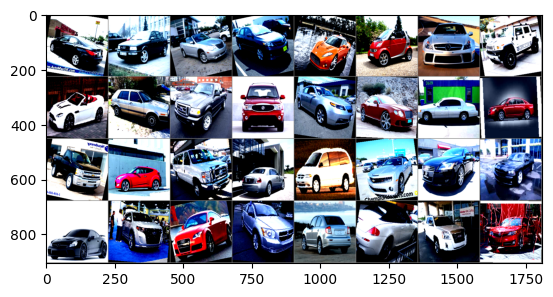

In [27]:
import torchvision

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

## Data distribution

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_class_distribution(data_loader):
    # Assuming the DataLoader is for a Subset of a ConcatDataset
    dataset = data_loader.dataset.dataset if isinstance(data_loader.dataset, Subset) else data_loader.dataset
    is_concat = isinstance(dataset, torch.utils.data.ConcatDataset)

    # Initialize class count dictionary
    if is_concat:
        # Assuming all sub-datasets have the same classes attribute, accessed from the first dataset
        all_classes = dataset.datasets[0].classes
    else:
        all_classes = dataset.classes

    class_counts = {class_name: 0 for class_name in all_classes}

    # Calculate class counts
    for _, labels in data_loader:
        for label in labels:
            class_name = all_classes[label.item()]
            class_counts[class_name] += 1

    # Plotting
    plt.figure(figsize=(30, 10))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.xticks(rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Classes in Dataset')
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


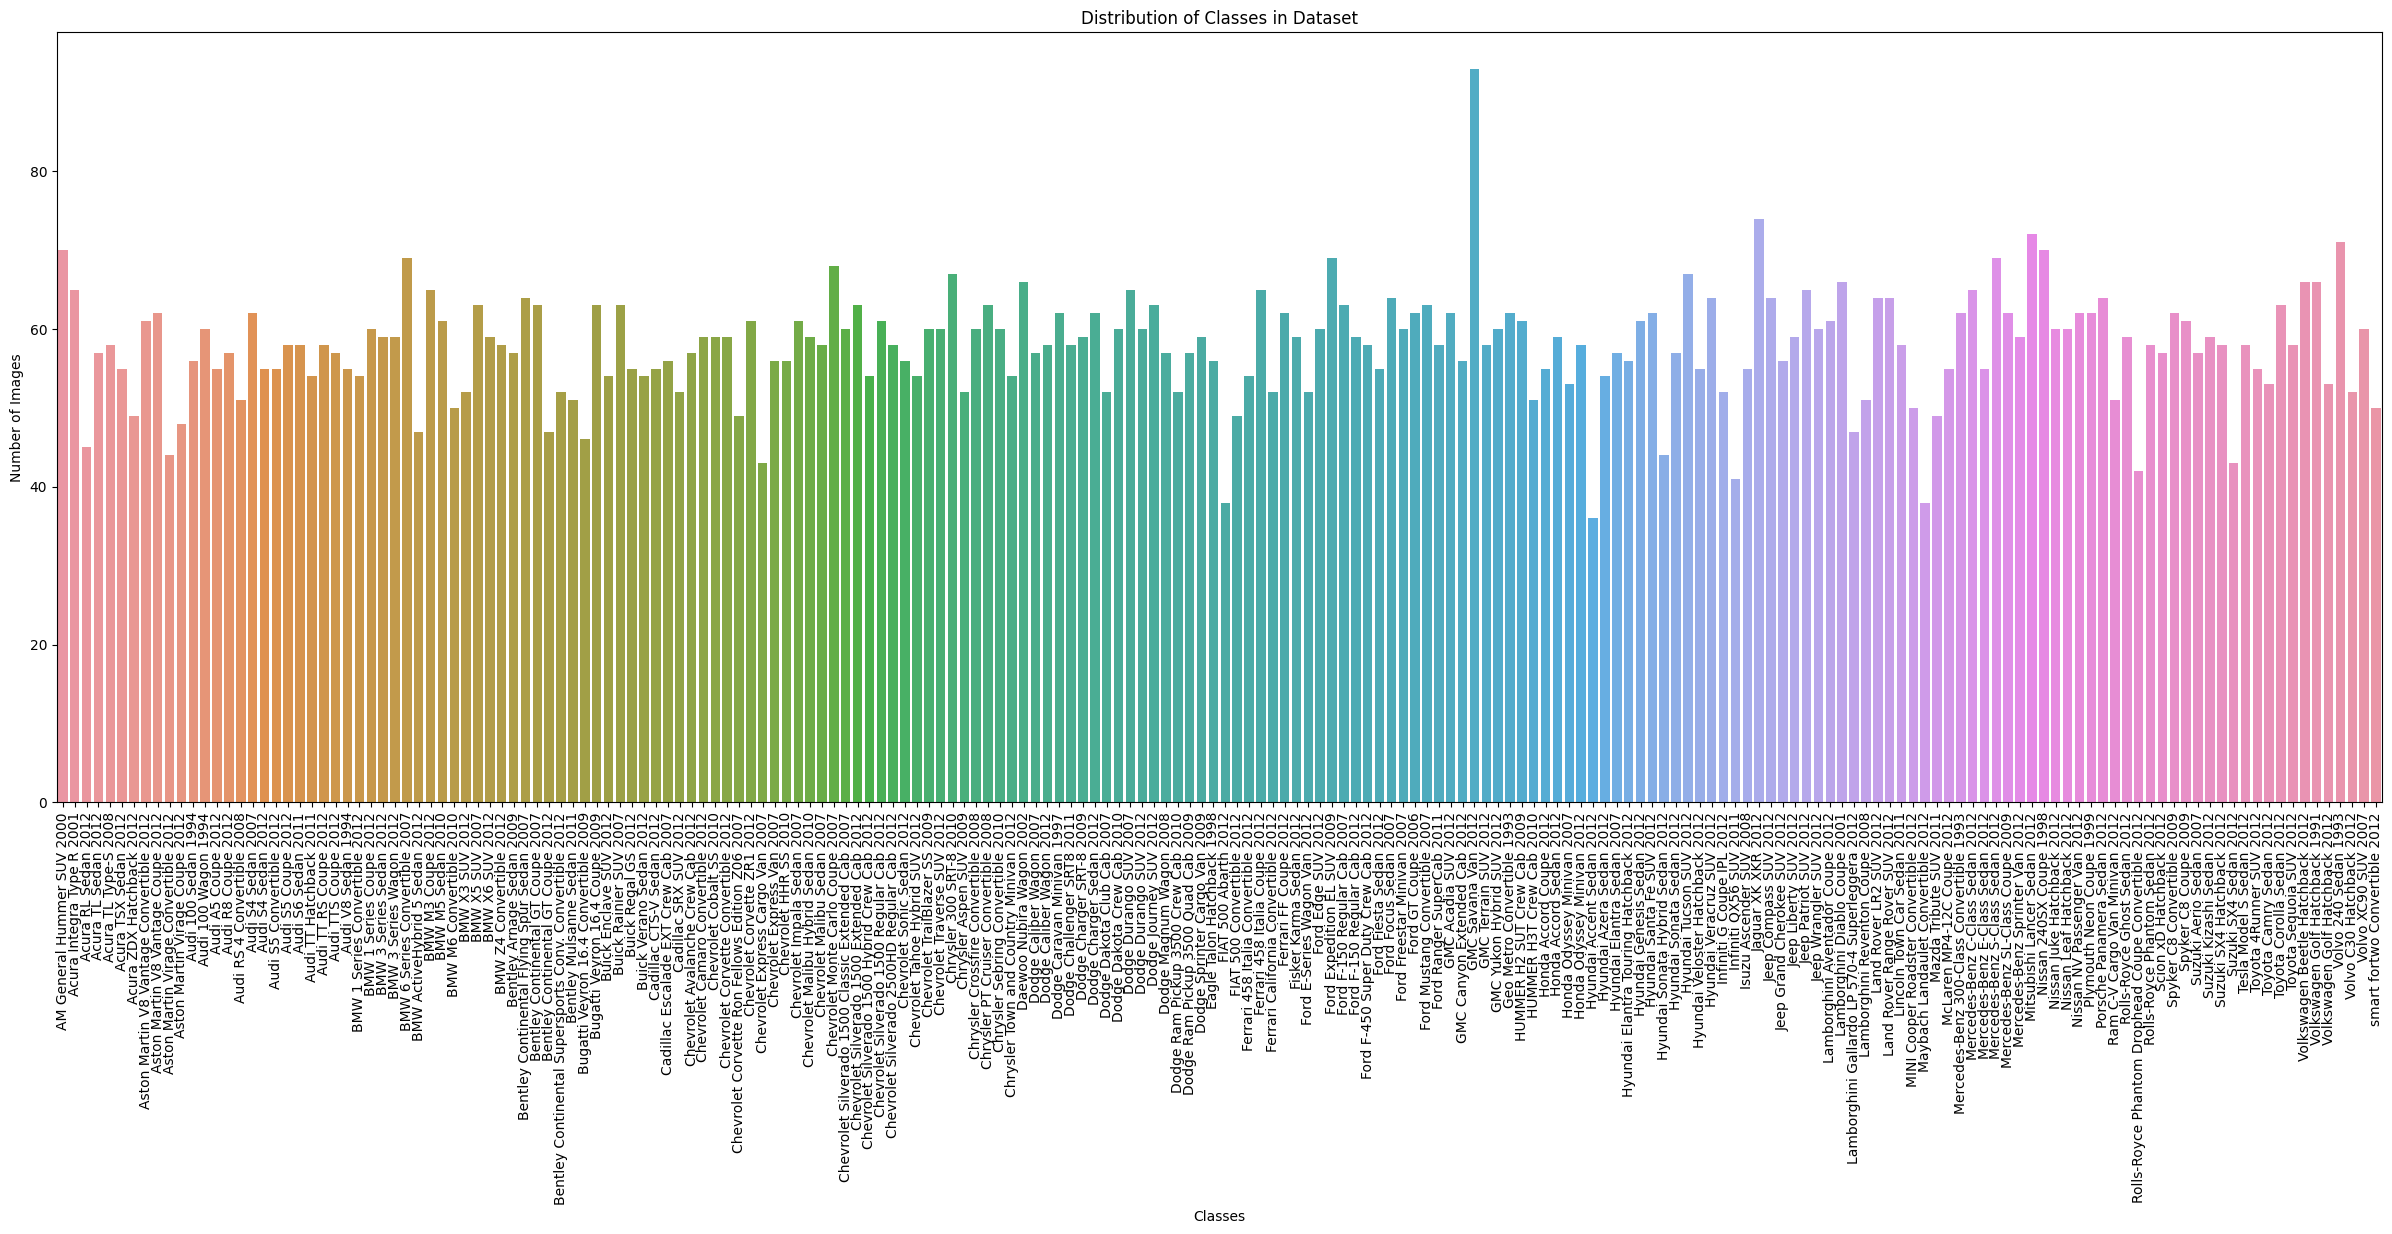

In [11]:
display_class_distribution(train_loader)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


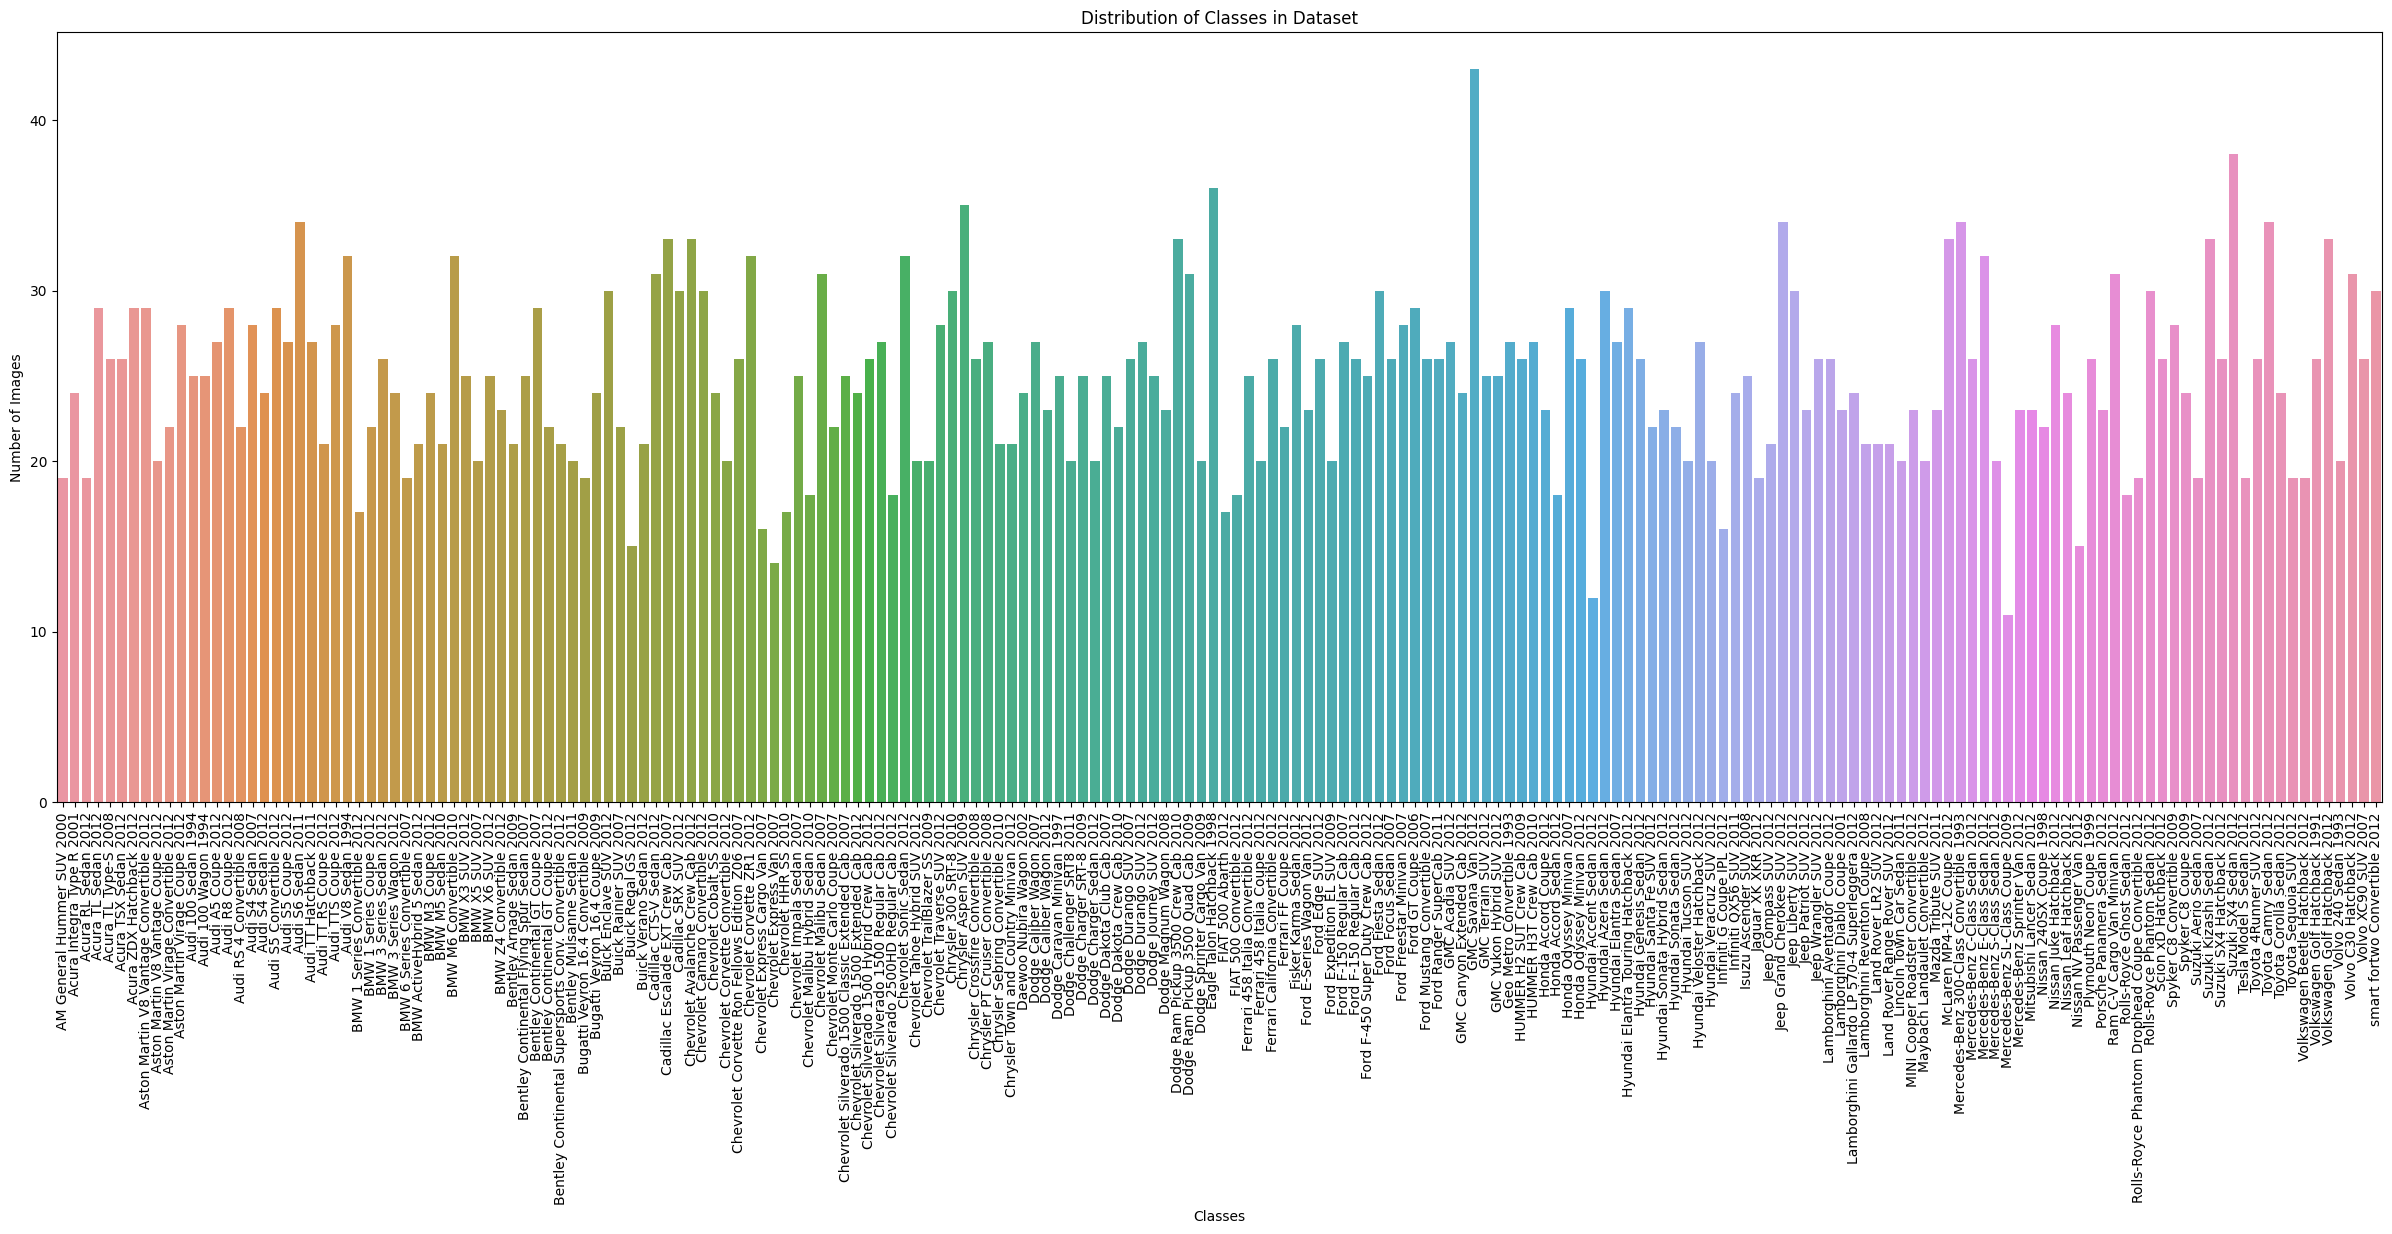

In [12]:
display_class_distribution(test_loader)

## ResNet18 pre-trained

In [147]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    model=model.to('cuda')
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(train_loader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
             # forward + backward + optimize
                
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/BATCH_SIZE*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [148]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [149]:
import torchvision.models as models

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 196)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [150]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [151]:
import time

model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, lrscheduler, n_epochs=20)

Epoch 1, duration: 53 s, loss: 4.3567, acc: 10.8824
Accuracy of the network on the test images: 27 %
Epoch 2, duration: 52 s, loss: 2.0673, acc: 50.0858
Accuracy of the network on the test images: 55 %
Epoch 3, duration: 52 s, loss: 1.0644, acc: 73.8235
Accuracy of the network on the test images: 66 %
Epoch 4, duration: 51 s, loss: 0.6379, acc: 84.6936
Accuracy of the network on the test images: 72 %
Epoch 5, duration: 52 s, loss: 0.4064, acc: 90.9191
Accuracy of the network on the test images: 78 %
Epoch 6, duration: 52 s, loss: 0.2771, acc: 93.7010
Accuracy of the network on the test images: 81 %
Epoch 7, duration: 52 s, loss: 0.1433, acc: 97.3407
Accuracy of the network on the test images: 88 %
Epoch 8, duration: 51 s, loss: 0.1037, acc: 98.2108
Accuracy of the network on the test images: 88 %
Epoch 9, duration: 51 s, loss: 0.0953, acc: 98.4681
Accuracy of the network on the test images: 89 %
Epoch 10, duration: 52 s, loss: 0.0860, acc: 98.6765
Accuracy of the network on the test im

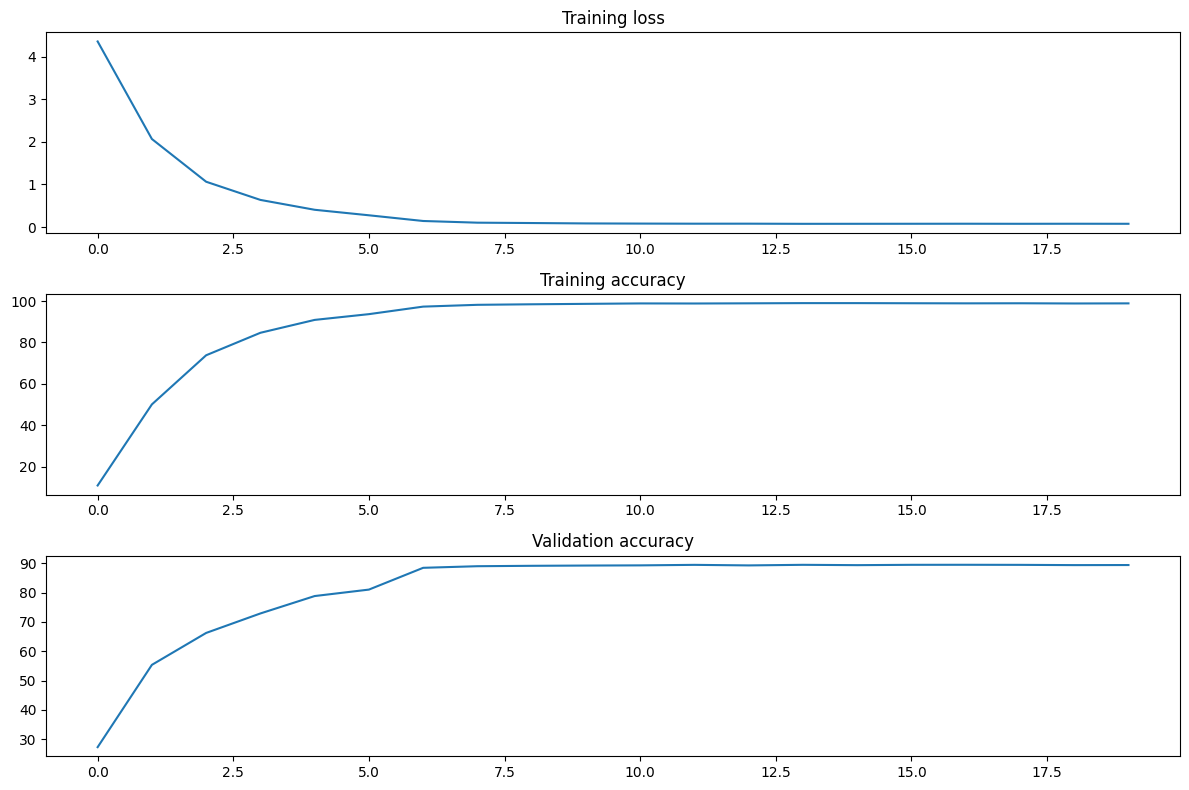

In [186]:
f, axarr = plt.subplots(3, 1, figsize=(12, 8))

# Plotting training losses on the first subplot
axarr[0].plot(training_losses)
axarr[0].set_title("Training loss")

# Plotting training accuracy on the second subplot
axarr[1].plot(training_accs)
axarr[1].set_title("Training accuracy")

# Plotting test accuracies on the third subplot
axarr[2].plot(test_accs)
axarr[2].set_title("Validation accuracy")

# Display the plots
plt.tight_layout()  # Adjust layout to make room for titles/labels
plt.show()

In [152]:
torch.save(model, 'best_model.pth')

In [46]:
accuracies = df_cm.apply(lambda x: x[x.name] / x.sum(), axis=1)

print("Accuracy per Class:\n", accuracies)

Accuracy per Class:
 0      0.777778
1      0.923077
2      0.909091
3      0.909091
4      1.000000
         ...   
191    0.894737
192    0.875000
193    0.800000
194    0.947368
195    1.000000
Length: 196, dtype: float64


In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

colors = ["white", "blue"]
cmap = LinearSegmentedColormap.from_list("custom_blue", colors)
nb_classes = 196
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

df_cm = pd.DataFrame(confusion_matrix)

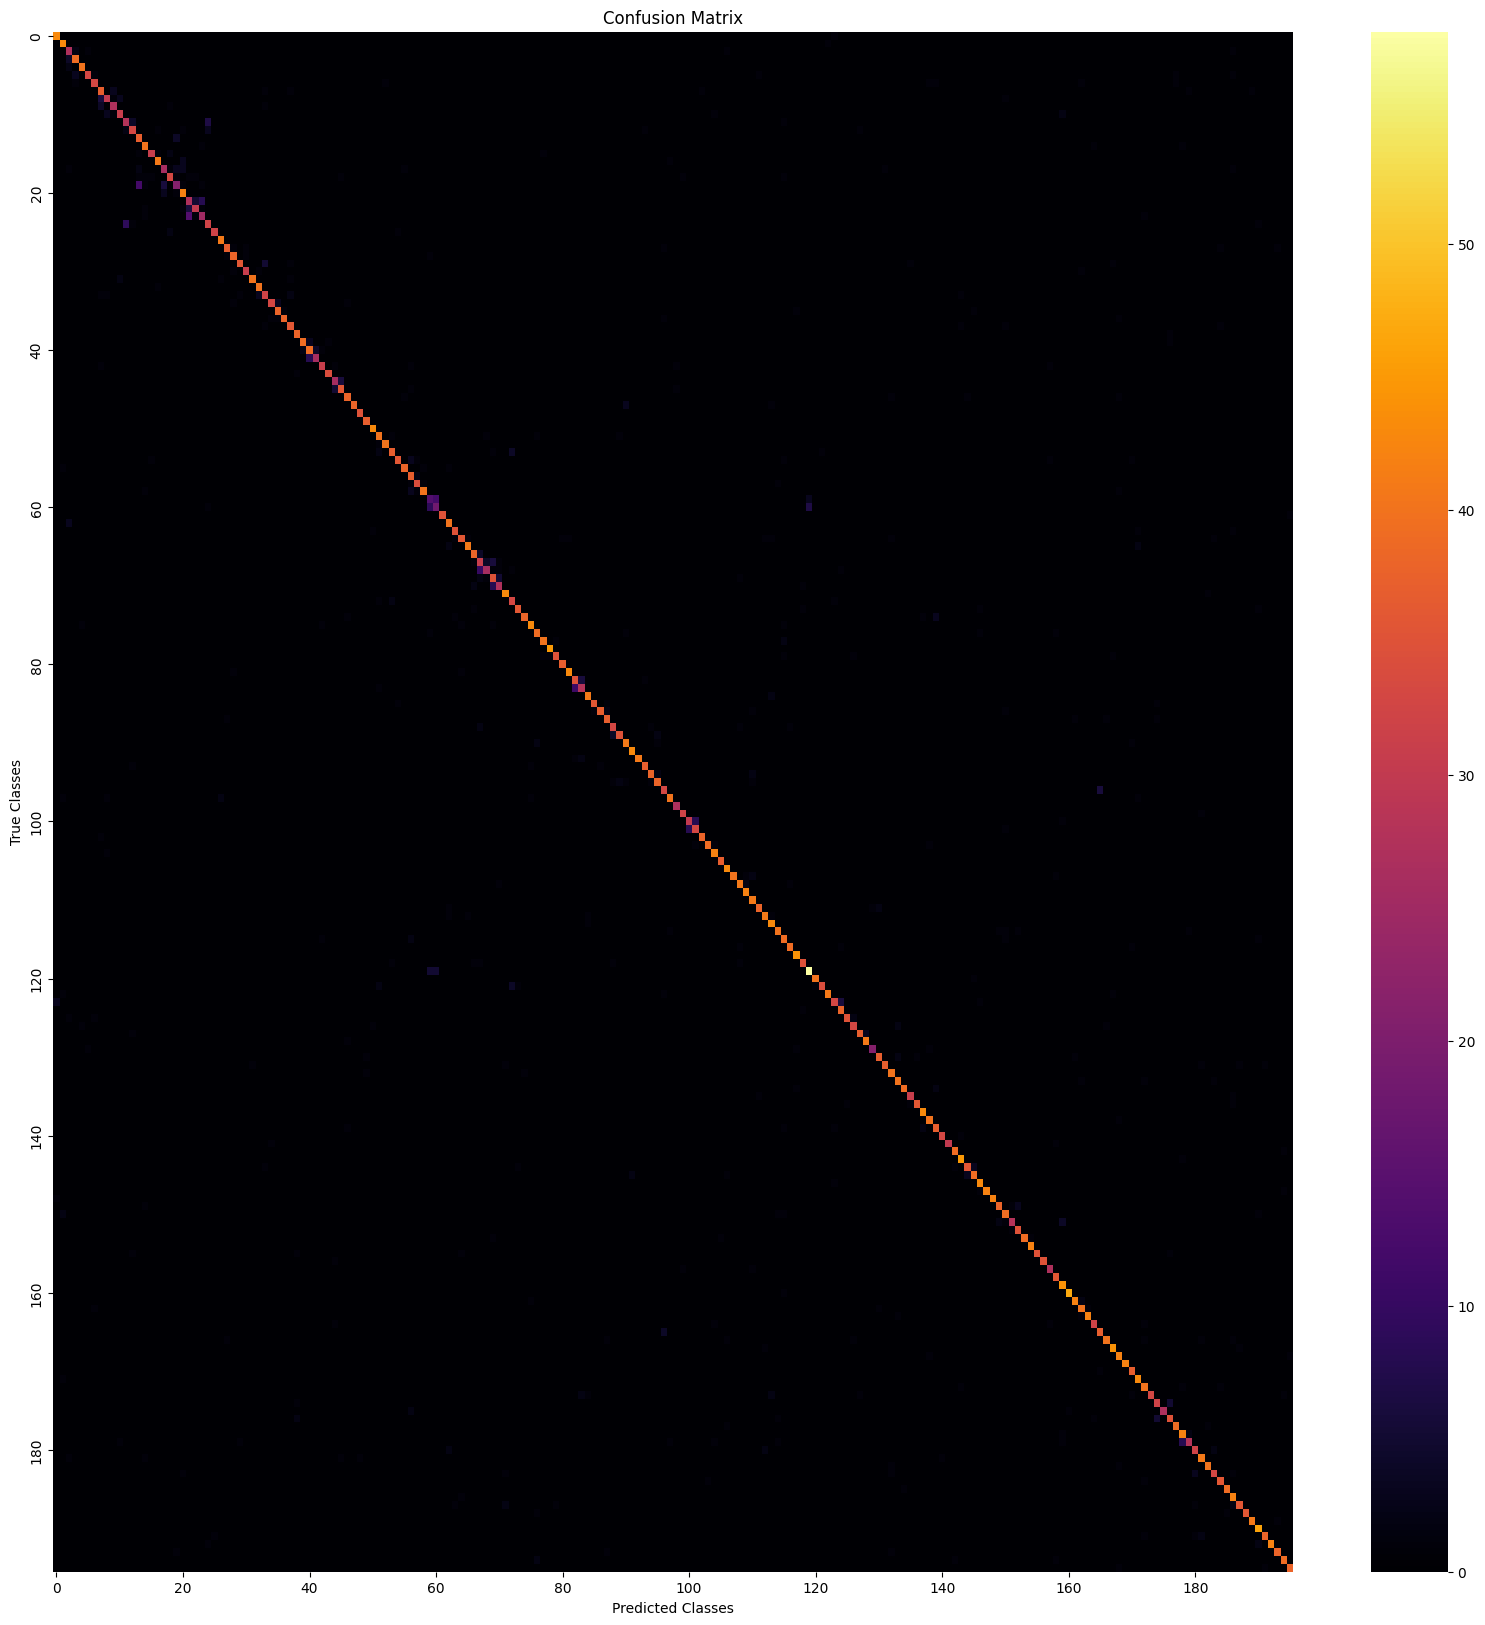

In [184]:
plt.figure(figsize=(20,20))
sns.heatmap(df_cm, cmap='inferno', xticklabels=20, yticklabels=20)  # Show labels every 20 classes
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

In [59]:
accuracies = pd.DataFrame(accuracies, columns=['Accuracy']).sort_values(by='Accuracy')
accuracies[:-1]

,Accuracy
59,0.333333
56,0.388889
23,0.411765
21,0.473684
158,0.500000
...,...
142,1.000000
4,1.000000
113,1.000000
148,1.000000


In [79]:
class_loader = DataLoader(worst_class_samples, batch_size=10, shuffle=True)

In [188]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [235]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
import numpy as np

# Setup hook
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hook to the first layer
model.layer1[0].conv1.register_forward_hook(get_activation('layer1_conv1'))

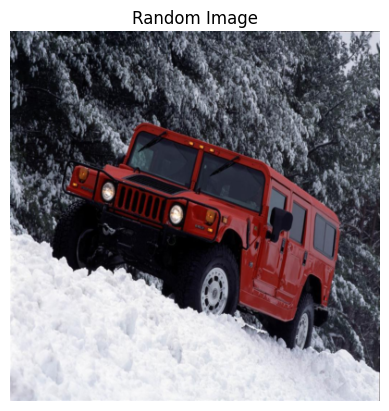

In [236]:
import random

def get_random_image(dataloader):
    total_batches = len(dataloader)
    random_batch_index = random.randint(0, total_batches - 1)

    for i, (images, labels) in enumerate(dataloader):
        if i == random_batch_index:
            random_image_index = random.randint(0, images.size(0) - 1)
            return images[random_image_index], labels[random_image_index]
        
        
# Get a random image and its corresponding label
image, label = get_random_image(test_loader)

image_formated = image.permute(1, 2, 0)  # Reorder dimensions to (H, W, C)

# Assuming the tensor was normalized or needs to be scaled to [0,1] range for display
image_formated = (image_formated - image_formated.min()) / (image_formated.max() - image_formated.min())  # Normalize to [0, 1]

plt.imshow(image_formated.numpy())  # Convert to numpy array and plot
plt.title("Random Image")
plt.axis('off')  # Hide axes
plt.show()

In [237]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def plot_activations(layer_activations, num_cols=8):
    # layer_activations should be a tensor of shape (num_filters, H, W)
    num_channels = layer_activations.size(0)
    fig, axes = plt.subplots((num_channels + num_cols - 1) // num_cols, num_cols, figsize=(num_cols * 2, (num_channels + num_cols - 1) // num_cols * 2))
    for i, ax in enumerate(axes.flat):
        if i < num_channels:
            ax.imshow(layer_activations[i].cpu().numpy(), cmap='mako')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
with torch.no_grad():    
    image = image.to(device)
    image = image.unsqueeze(0)
    output = model(image)
    layer_activations = activations['layer1_conv1']
    plot_activations(layer_activations)

In [178]:
from sklearn.decomposition import PCA

def get_activations(dataloader, device='cpu'):
    activations = []
    model.to(device)
    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        # Extracting activations from the first layer
        with torch.no_grad():
            output = model.conv1(inputs)
        activations.append(output.flatten(start_dim=1))  # Flatten all dimensions except batch
    # Concatenate all batches
    activations = torch.cat(activations, dim=0)
    return activations.cpu().numpy()  # Convert to NumPy array for PCA

In [ ]:
test_loader_pca = DataLoader(test_subset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
activations = get_activations(test_loader, device='cpu')

In [ ]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_activations = pca.fit_transform(activations)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(reduced_activations[:, 0], reduced_activations[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Model Activations')
plt.show()

# Fine-tuning by first freezing pre-trained weights

We only train the last fully connected layers first while freezing the pre-trained weights. After few epochs, we then train all the weights. This will allow us to initialize the weight of last fully connected layer into with better values rather than starting from a random initialization

In [165]:
import torchvision.models as models

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 196)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Training parameters

In [149]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = optim.AdamW(model.fc.parameters(), lr=0.001, weight_decay=0.01)
#optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
#optimizer_ft = optim.Adam(model.fc.parameters(), lr=3e-3)
#optimizer = optim.Adam(model.parameters(), lr=3e-4)
#lrscheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

#### Training

In [150]:
import time

model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer_ft, lrscheduler, n_epochs=5)
for param in model.parameters():
    param.requires_grad = True
model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, lrscheduler, n_epochs=15)

Epoch 1, duration: 51 s, loss: 4.7069, acc: 7.7392
Accuracy of the network on the test images: 17 %
Epoch 2, duration: 52 s, loss: 3.4632, acc: 24.6682
Accuracy of the network on the test images: 22 %
Epoch 3, duration: 51 s, loss: 2.9030, acc: 34.5293
Accuracy of the network on the test images: 26 %
Epoch 4, duration: 51 s, loss: 2.5619, acc: 40.7176
Accuracy of the network on the test images: 31 %
Epoch 5, duration: 51 s, loss: 2.3183, acc: 45.6481
Accuracy of the network on the test images: 32 %
Finished Training
Epoch 1, duration: 55 s, loss: 1.7384, acc: 60.9105
Accuracy of the network on the test images: 46 %
Epoch 2, duration: 55 s, loss: 1.3724, acc: 70.0617
Accuracy of the network on the test images: 52 %
Epoch 3, duration: 54 s, loss: 1.1993, acc: 74.5139
Accuracy of the network on the test images: 55 %
Epoch 4, duration: 55 s, loss: 1.0752, acc: 77.6852
Accuracy of the network on the test images: 57 %
Epoch 5, duration: 55 s, loss: 0.9688, acc: 80.6327
Accuracy of the networ


KeyboardInterrupt



In [64]:
model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, lrscheduler, n_epochs=5)

Epoch 1, duration: 55 s, loss: 0.0445, acc: 99.1127
Accuracy of the network on the test images: 80 %
Epoch 2, duration: 55 s, loss: 0.0293, acc: 99.3981
Accuracy of the network on the test images: 81 %
Epoch 3, duration: 54 s, loss: 0.0321, acc: 99.3981
Accuracy of the network on the test images: 83 %
Epoch 4, duration: 54 s, loss: 0.0341, acc: 99.3056
Accuracy of the network on the test images: 83 %
Epoch 5, duration: 55 s, loss: 0.0194, acc: 99.5293
Accuracy of the network on the test images: 82 %
Finished Training


# Results analytics

In [153]:
import torch
from torchvision.transforms import ToPILImage

# Assume model, test_loader and device are already defined
model.eval()  # Set the model to evaluation mode

misclassified_examples = []

with torch.no_grad():  # No need to track gradients
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        misclassifications = predictions != labels
        for image, label, prediction in zip(images[misclassifications], labels[misclassifications], predictions[misclassifications]):
            misclassified_examples.append((image.cpu(), label.cpu(), prediction.cpu()))

In [160]:
misclassified_df = [{'Label': label.item(), 'Prediction': prediction.item()} for _, label, prediction in misclassified_examples]
misclassified_df = pd.DataFrame(misclassified_df)
misclassified_df

,Label,Prediction
0,0,123
1,1,122
2,2,186
3,2,3
4,2,3
...,...,...
849,194,76
850,194,158
851,194,76
852,195,168


In [167]:
misclassified_df['Label_name'] = misclassified_df['Label'].apply(lambda x : train_set.classes[x])
misclassified_df['Prediction_name'] = misclassified_df['Prediction'].apply(lambda x : train_set.classes[x])
misclassified_df.to_csv('error_df_best_model.csv', index=False)

In [172]:
misclassified_df[:20]

,Label,Prediction,Label_name,Prediction_name
0,0,123,AM General Hummer SUV 2000,HUMMER H2 SUT Crew Cab 2009
1,1,122,Acura Integra Type R 2001,Geo Metro Convertible 1993
2,2,186,Acura RL Sedan 2012,Toyota Camry Sedan 2012
3,2,3,Acura RL Sedan 2012,Acura TL Sedan 2012
4,2,3,Acura RL Sedan 2012,Acura TL Sedan 2012
5,2,5,Acura RL Sedan 2012,Acura TSX Sedan 2012
6,2,106,Acura RL Sedan 2012,Ford Edge SUV 2012
7,3,2,Acura TL Sedan 2012,Acura RL Sedan 2012
8,3,2,Acura TL Sedan 2012,Acura RL Sedan 2012
9,3,2,Acura TL Sedan 2012,Acura RL Sedan 2012


In [163]:
from PIL import Image
import matplotlib.pyplot as plt

def retrieve_images_of_class(dataset, class_index, num_images=1):
    images = []
    for image, label in train_set:
        if label == class_index:
            images.append(image)
            if len(images) == num_images:
                break
    return images

### TRUE CLASS ###


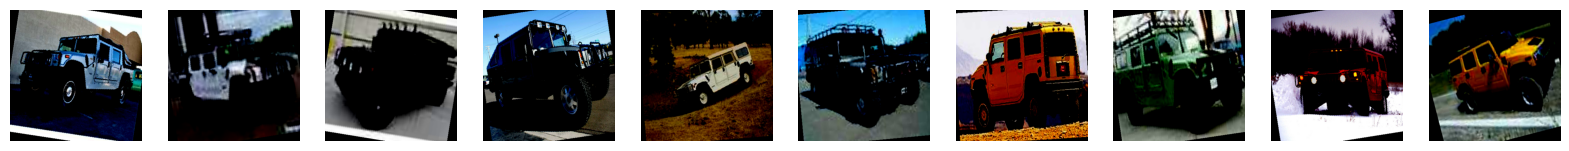

### PREDICTED CLASS ###


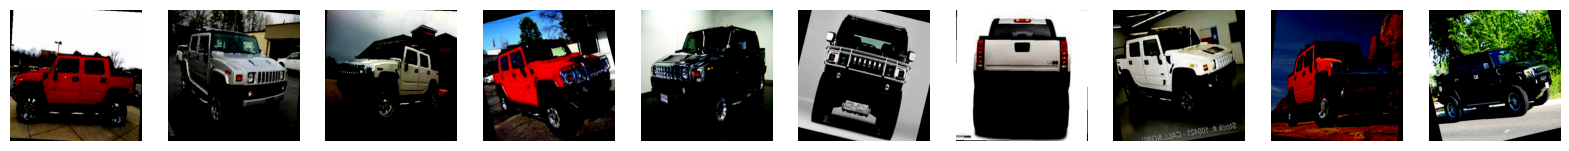

In [164]:
print("### TRUE CLASS ###")
# Retrieve images|
desired_images = retrieve_images_of_class(train_set, 0, num_images=10)

# Display the images
fig, axes = plt.subplots(1, len(desired_images), figsize=(20, 5))
for ax, img_tensor in zip(axes, desired_images):
    ax.imshow(img_tensor.permute(1, 2, 0))  # Reorder dimensions for displaying
    ax.axis('off')
plt.show()


print("### PREDICTED CLASS ###")
# Retrieve images|
desired_images = retrieve_images_of_class(train_set, 123, num_images=10)

# Display the images
fig, axes = plt.subplots(1, len(desired_images), figsize=(20, 5))
for ax, img_tensor in zip(axes, desired_images):
    ax.imshow(img_tensor.permute(1, 2, 0))  # Reorder dimensions for displaying
    ax.axis('off')
plt.show()

In [ ]:
# Assuming you want to print/inspect some misclassified examples
for image, label, prediction in misclassified_examples:  # Adjust as needed to view more cases
    if (label.item() in [17, 23, 21]):
        imshow(torchvision.utils.make_grid(image.unsqueeze(0)))
        print(f"True label: {label.item()}, Predicted label: {prediction.item()}")

In [119]:
import collections

# Assuming misclassified_examples is a list of tuples (image, true_label, predicted_label)
error_counts = collections.Counter()
for _, true_label, _ in misclassified_examples:
    error_counts[true_label.item()] += 1

In [120]:
import pandas as pd

# Convert the counter to a DataFrame
error_df = pd.DataFrame(list(error_counts.items()), columns=['Class', 'Error Count'])

In [130]:
error_df = error_df.sort_values(by="Error Count", ascending=False)

In [131]:
error_df['Class_name'] = error_df['Class'].apply(lambda x : train_set.classes[x])

In [132]:
error_df

,Class,Error Count,Class_name
8,60,13,Chevrolet Express Van 2007
27,70,9,Chevrolet Silverado 2500HD Regular Cab 2012
31,68,7,Chevrolet Silverado 1500 Hybrid Crew Cab 2012
104,186,7,Toyota Camry Sedan 2012
55,12,7,Audi 100 Wagon 1994
...,...,...,...
139,157,1,Maybach Landaulet Convertible 2012
144,149,1,Lamborghini Aventador Coupe 2012
145,142,1,Isuzu Ascender SUV 2008
154,169,1,Nissan Leaf Hatchback 2012


In [133]:
error_df.to_csv('error_df_v1.csv', index=False)

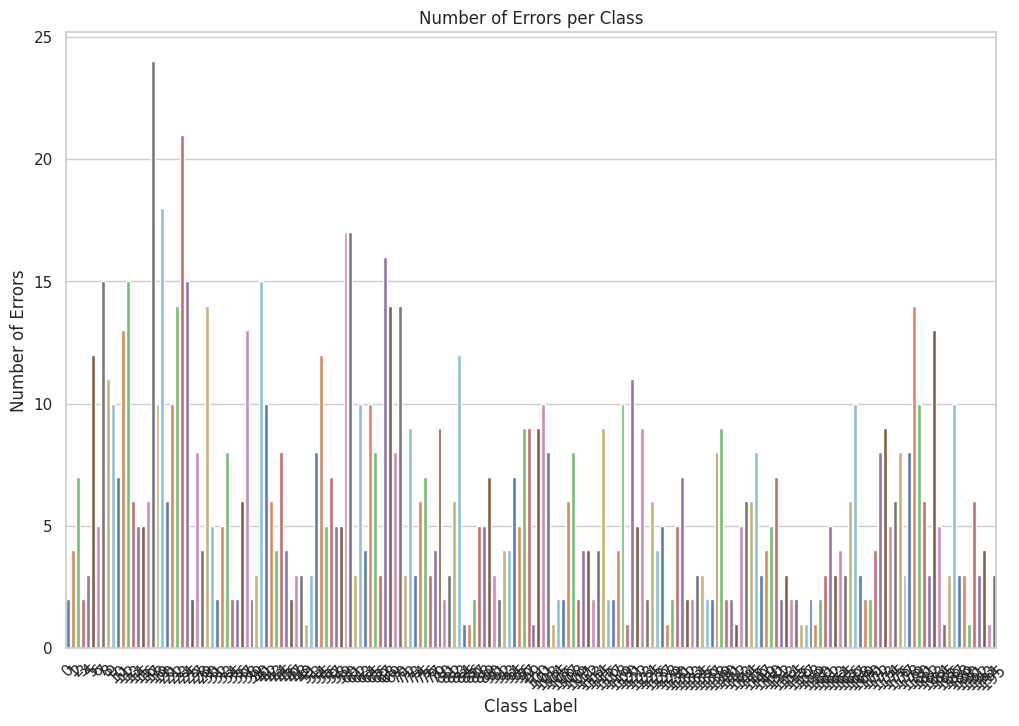

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setup seaborn
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Class', y='Error Count', data=error_df, palette='muted')

plt.title('Number of Errors per Class')
plt.xlabel('Class Label')
plt.ylabel('Number of Errors')
plt.xticks(rotation=45)  # Rotate class labels for better readability if needed
plt.show()

## HP OPTIMIZATION

In [22]:
criterion = nn.CrossEntropyLoss()
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [23]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import optuna

def objective(trial):
    # Hyperparameters to optimize
    lr_1 = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    lr_2 = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Model setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = torch.nn.Linear(model.fc.in_features, 196)  # Adjust according to your problem
    model.to(device)
    

    # Optimizer setup
    optimizer_ft = optim.SGD(model.fc.parameters(), lr=lr_1, momentum=0.9)
    optimizer = optim.SGD(model.parameters(), lr=lr_2, momentum=0.9)


    # Training
    
    model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer_ft, lrscheduler, n_epochs=5)
    for param in model.parameters():
        param.requires_grad = True
    model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, lrscheduler, n_epochs=10)
    
    accuracy = max(training_accs)
    
    return accuracy  # Objective value to maximize


In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Run 50 trials

print('Best parameters:', study.best_params)  # Best parameters found
print('Best accuracy:', study.best_value)  # Best accuracy achieved

[I 2024-04-24 07:38:40,601] A new study created in memory with name: no-name-e2d77b17-bd68-4c62-888c-78ad46690945
/tmp/ipykernel_34/3572214557.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr_1 = trial.suggest_loguniform('lr', 1e-4, 1e-1)
/tmp/ipykernel_34/3572214557.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr_2 = trial.suggest_loguniform('lr', 1e-4, 1e-1)


Epoch 1, duration: 52 s, loss: 8.8016, acc: 9.4599
Accuracy of the network on the test images: 15 %
Epoch 2, duration: 52 s, loss: 7.7675, acc: 21.3735
Accuracy of the network on the test images: 18 %
Epoch 3, duration: 52 s, loss: 7.2776, acc: 27.5154
Accuracy of the network on the test images: 22 %
Epoch 4, duration: 52 s, loss: 6.7663, acc: 31.1574
Accuracy of the network on the test images: 22 %
Epoch 5, duration: 52 s, loss: 6.4903, acc: 34.2747
Accuracy of the network on the test images: 26 %
Finished Training
Epoch 1, duration: 56 s, loss: 6.1638, acc: 0.6404
Accuracy of the network on the test images: 0 %
Epoch 2, duration: 56 s, loss: 5.2972, acc: 0.7639
Accuracy of the network on the test images: 1 %
Epoch 3, duration: 57 s, loss: 5.2711, acc: 0.8256
Accuracy of the network on the test images: 0 %
Epoch 4, duration: 56 s, loss: 5.2602, acc: 0.7948
Accuracy of the network on the test images: 0 %
Epoch 5, duration: 56 s, loss: 5.2499, acc: 0.8873
Accuracy of the network on the 

[W 2024-04-24 07:51:30,783] Trial 0 failed with parameters: {'lr': 0.04740299074275081, 'batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_34/3572214557.py", line 37, in objective
    model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, lrscheduler, n_epochs=10)
  File "/tmp/ipykernel_34/1701033685.py", line 13, in train_model
    for i, data in enumerate(train_loader, 0):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1328, in _next_data
    idx, data = self._get_data()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1294, in _get_da